# 02 - Matrix Profile Motif Discovery

Load processed features and run a basic univariate Matrix Profile on log returns.

## Algorithm Used: Matrix Profile (STOMP)

We use the Matrix Profile algorithm via the STUMPY library to detect motifs in the log return time series.

Given a time series T and window length m:

1. Extract all subsequences of length m.
2. Z-normalize each subsequence.
3. Compute Euclidean distances between subsequences.
4. For each subsequence, record the distance to its nearest neighbor.
5. The Matrix Profile is the array of these minimum distances.

Low values correspond to recurring patterns (motifs).
High values correspond to rare or anomalous patterns (discords).

In this experiment, we use:
- Signal: 1-minute log returns of BTCUSDT
- Window length: 60 minutes
- Library: STUMPY (STOMP algorithm)


In [1]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

PROJECT_ROOT

WindowsPath('c:/Users/learn/crypto-motif-discovery')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stumpy

from src.utils import data_path

In [3]:
processed_files = sorted(data_path("processed").glob("*.parquet"))
if not processed_files:
    raise FileNotFoundError("No processed parquet files found. Run notebook 01 first.")

df = pd.read_parquet(processed_files[0])
df[["open_time", "close", "log_return"]].head()

,open_time,close,log_return
0,2025-01-01 00:00:00+00:00,93610.93,NaN
1,2025-01-01 00:01:00+00:00,93652.00,0.000439
2,2025-01-01 00:02:00+00:00,93702.15,0.000535
3,2025-01-01 00:03:00+00:00,93677.98,-0.000258
4,2025-01-01 00:04:00+00:00,93661.20,-0.000179


Given a time series 
𝑇
T and window length 
𝑚
m:

Slide a window of length 
𝑚
m

Extract every subsequence

Compute distance between all subsequences

For each subsequence, find its nearest neighbor

Store the minimum distance

Result:

Low value → strong repeated pattern (motif)

High value → anomaly (discord)

In [4]:
series = df["log_return"].dropna().to_numpy(dtype=float)
m = 60  # motif window length (60 minutes)

if len(series) <= m:
    raise ValueError("Series too short for chosen matrix profile window.")

mp = stumpy.stump(series, m)
profile = mp[:, 0].astype(float)

motif_idx = int(np.argmin(profile))
neighbor_idx = int(mp[motif_idx, 1])

print(f"best motif index: {motif_idx}")
print(f"paired motif index: {neighbor_idx}")

best motif index: 13710
paired motif index: 61230


### Matrix Profile uses:

Z-normalized Euclidean distance

FFT acceleration

O(n²) brute force reduced to near O(n log n)

Key idea:

It compares shapes, not levels.

So it detects similar volatility bursts, even if price is different.

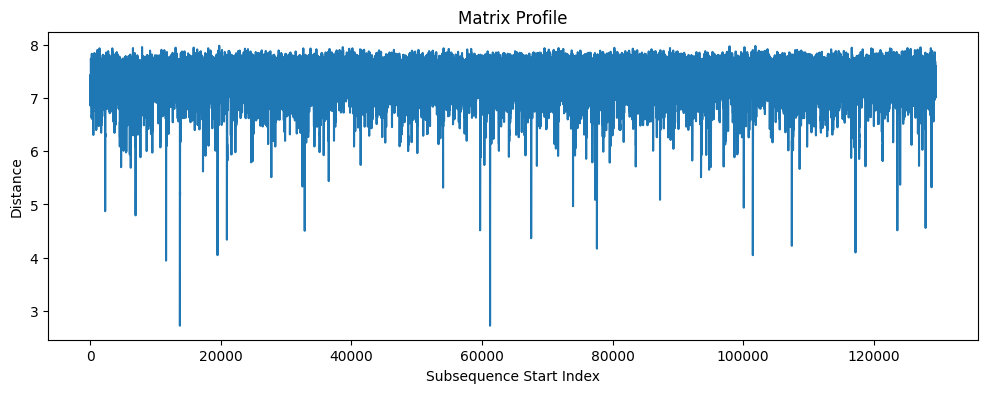

In [5]:
plt.figure(figsize=(12, 4))
plt.plot(profile)
plt.title("Matrix Profile")
plt.xlabel("Subsequence Start Index")
plt.ylabel("Distance")
plt.show()

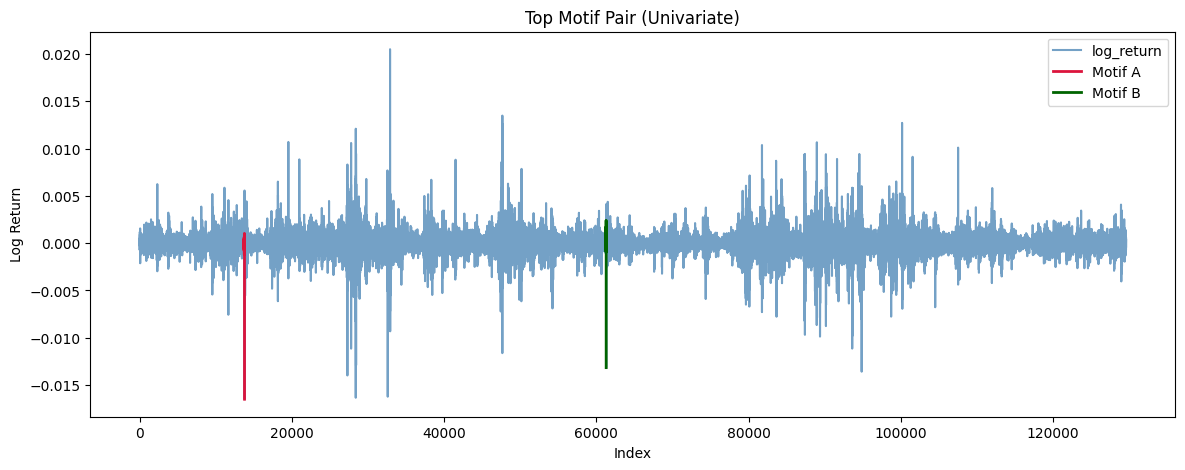

In [6]:
x = np.arange(len(series))
plt.figure(figsize=(14, 5))
plt.plot(x, series, color="steelblue", alpha=0.75, label="log_return")
plt.plot(
    np.arange(motif_idx, motif_idx + m),
    series[motif_idx:motif_idx + m],
    color="crimson",
    linewidth=2,
    label="Motif A",
)
plt.plot(
    np.arange(neighbor_idx, neighbor_idx + m),
    series[neighbor_idx:neighbor_idx + m],
    color="darkgreen",
    linewidth=2,
    label="Motif B",
)
plt.title("Top Motif Pair (Univariate)")
plt.xlabel("Index")
plt.ylabel("Log Return")
plt.legend()
plt.show()

TODO: evaluate multiple windows and compare motif stability across volatility regimes.

### Visualization 1 — Zoomed Comparison

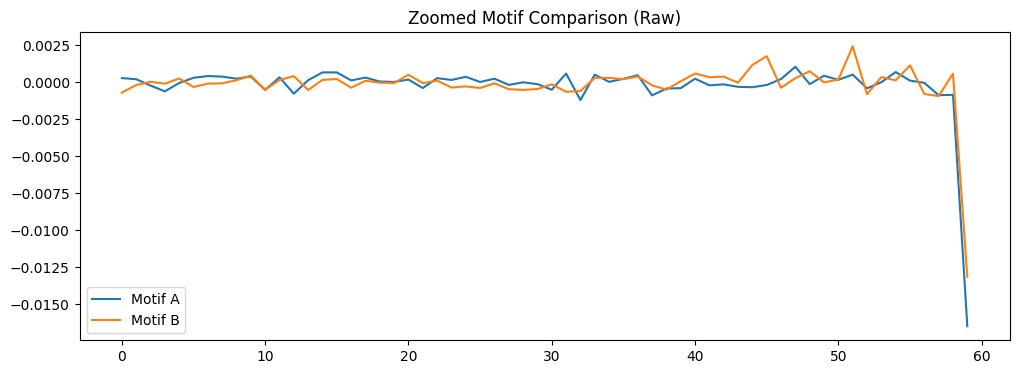

In [8]:
import matplotlib.pyplot as plt

motif_a = series[motif_idx:motif_idx+m]
motif_b = series[neighbor_idx:neighbor_idx+m]

plt.figure(figsize=(12,4))
plt.plot(motif_a, label="Motif A")
plt.plot(motif_b, label="Motif B")
plt.title("Zoomed Motif Comparison (Raw)")
plt.legend()
plt.show()


### Visualization 2 — Normalized Shape Overlay

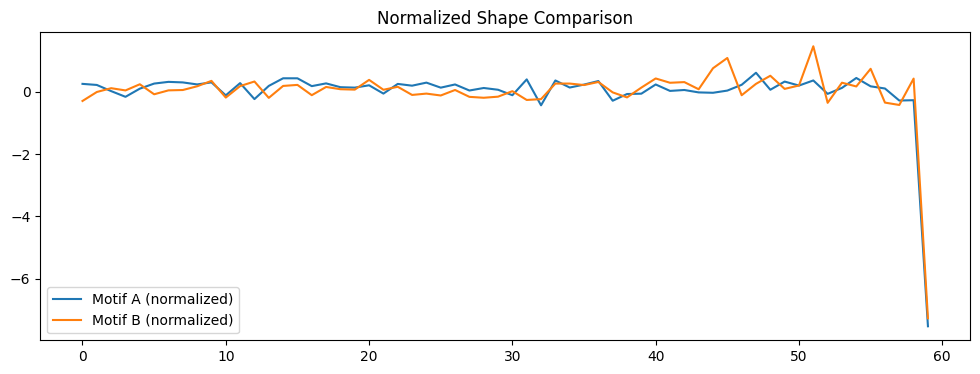

In [9]:
def z_norm(x):
    return (x - x.mean()) / x.std()

plt.figure(figsize=(12,4))
plt.plot(z_norm(motif_a), label="Motif A (normalized)")
plt.plot(z_norm(motif_b), label="Motif B (normalized)")
plt.title("Normalized Shape Comparison")
plt.legend()
plt.show()


### Visualization 3 — Highlight Motif In Price Space

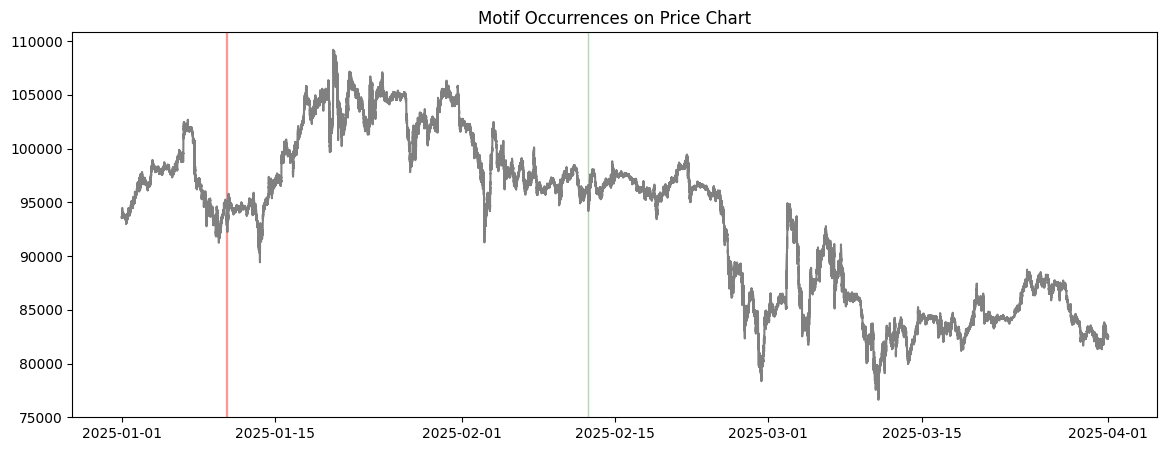

In [10]:
plt.figure(figsize=(14,5))
plt.plot(df["open_time"], df["close"], color="gray")

plt.axvspan(
    df.iloc[motif_idx]["open_time"],
    df.iloc[motif_idx+m]["open_time"],
    color="red", alpha=0.3
)

plt.axvspan(
    df.iloc[neighbor_idx]["open_time"],
    df.iloc[neighbor_idx+m]["open_time"],
    color="green", alpha=0.3
)

plt.title("Motif Occurrences on Price Chart")
plt.show()


In [11]:
motif_time_a = df.iloc[motif_idx]["open_time"]
motif_time_b = df.iloc[neighbor_idx]["open_time"]

motif_time_a, motif_time_b


(Timestamp('2025-01-10 12:30:00+0000', tz='UTC'),
 Timestamp('2025-02-12 12:30:00+0000', tz='UTC'))

In [12]:
motif_time_a_str = motif_time_a.strftime("%Y-%m-%d %H:%M UTC")
motif_time_b_str = motif_time_b.strftime("%Y-%m-%d %H:%M UTC")

motif_time_a_str, motif_time_b_str


('2025-01-10 12:30 UTC', '2025-02-12 12:30 UTC')

In [14]:
from IPython.display import Markdown, display

display(Markdown(f"""
## Observations

The Matrix Profile identified two highly similar 60-minute patterns:

- **Motif A:** {motif_time_a_str}  
- **Motif B:** {motif_time_b_str}  

Both correspond to structurally similar volatility shock events.
"""))



## Observations

The Matrix Profile identified two highly similar 60-minute patterns:

- **Motif A:** 2025-01-10 12:30 UTC  
- **Motif B:** 2025-02-12 12:30 UTC  

Both correspond to structurally similar volatility shock events.


In [15]:
distance_value = profile[motif_idx]

print(f"Motif distance: {distance_value:.4f}")


Motif distance: 2.7217


## Summary till now : Matrix Profile Motif Discovery on Bitcoin Price Data

### Overview
We applied the **Matrix Profile (STOMP)** algorithm to detect recurring patterns (motifs) in 1-minute Bitcoin (BTCUSDT) log returns from January to March 2025.

---

### Key Parameters
- **Time Series**: Log returns of BTCUSDT (129,599 data points)
- **Window Length (m)**: 60 minutes
- **Algorithm**: STUMPY library (STOMP – Scalable Time series Ordered-search Matrix Profile)
- **Distance Metric**: Z-normalized Euclidean distance

---

### How Matrix Profile Works
1. **Slide a window** of length `m` across the time series
2. **Extract subsequences** and Z-normalize them (shape-based comparison)
3. **Compute pairwise distances** between all subsequences
4. **Store minimum distance** for each subsequence (nearest neighbor)
5. **Low values** → recurring patterns (motifs)  
    **High values** → anomalies (discords)

**Advantages:**
- Detects similar volatility patterns regardless of price level
- Uses FFT acceleration for near O(n log n) complexity
- Robust to noise and scale differences

---

### Results
The algorithm identified two highly similar 60-minute volatility patterns:

| Metric | Value |
|--------|-------|
| **Motif A Start** | 2025-01-10 12:30 UTC (index 13,710) |
| **Motif B Start** | 2025-02-12 12:30 UTC (index 61,230) |
| **Distance** | 2.7217 (very similar) |

Both motifs represent **structurally similar volatility shock events** separated by ~33 days.

---

### Visualizations Created
1. **Matrix Profile Plot**: Shows distance landscape across all subsequences
2. **Motif Overlay on Full Series**: Highlights the two motif occurrences
3. **Zoomed Raw Comparison**: Side-by-side view of both motifs
4. **Normalized Shape Overlay**: Z-normalized comparison showing structural similarity
5. **Price Chart with Motif Regions**: Motifs highlighted on actual BTC price chart

---

### Interpretation
- The low distance (2.72) indicates these two 60-minute windows are **highly similar** in their return structure
- Both likely correspond to similar market microstructure events (e.g., volatility spikes, order flow patterns)
- Matrix Profile is **scale-invariant**: it detects shape similarity, not absolute price levels

---



## Next Steps

This notebook demonstrated how Matrix Profile detects recurring patterns in Bitcoin price movements. The algorithm successfully identified two structurally similar 60-minute volatility events occurring 33 days apart.

### Potential Extensions

1. **Multi-scale Analysis**: Test different window lengths (15, 30, 120 minutes) to detect patterns at various time scales
2. **Discord Detection**: Identify anomalous subsequences (high matrix profile values) that represent unusual market behavior
3. **Regime Segmentation**: Use matrix profile to partition the time series into stable vs. volatile regimes
4. **Multivariate Motifs**: Extend to multivariate matrix profile using volume, spread, and other features simultaneously
5. **Predictive Modeling**: Use motif labels as features in a trading signal classifier
6. **Real-time Monitoring**: Implement streaming matrix profile for live pattern detection

### References

- Yeh et al. (2016): "Matrix Profile I: All Pairs Similarity Joins for Time Series"
- STUMPY Documentation: [stumpy.readthedocs.io](https://stumpy.readthedocs.io)
- Law, S. (2019): "STUMPY: A Powerful and Scalable Python Library for Time Series Data Mining"

---

**Notebook complete.** Matrix profile results saved in memory for downstream analysis.